# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import csv
import winsound

from functions import *
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.decomposition import PCA
from scipy.stats import *
from sklearn.inspection import PartialDependenceDisplay

from matplotlib.patches import Patch
from matplotlib.lines import Line2D



%matplotlib notebook
%matplotlib inline
    
%load_ext autoreload
%autoreload 2

# Load features

- load_train_meta(vals = False)
- load_features(vals = False)

In [2]:
n = 0

Xmeta = load_train_meta()
Xwave = load_wave_features()

print("Shape of Xmeta:", Xmeta.shape)
print("Shape of Xwave", Xwave.shape)

Shape of Xmeta: (1100, 5)
Shape of Xwave (1100, 88)


## Data Exploration

In [3]:
D = Xmeta['direction']
G = Xmeta['group']
S = Xmeta['speed']
L = Xmeta['label']

- plot_sorted_counts(data, label, xtick=True, rot=90, sorted=True, coloring=None)



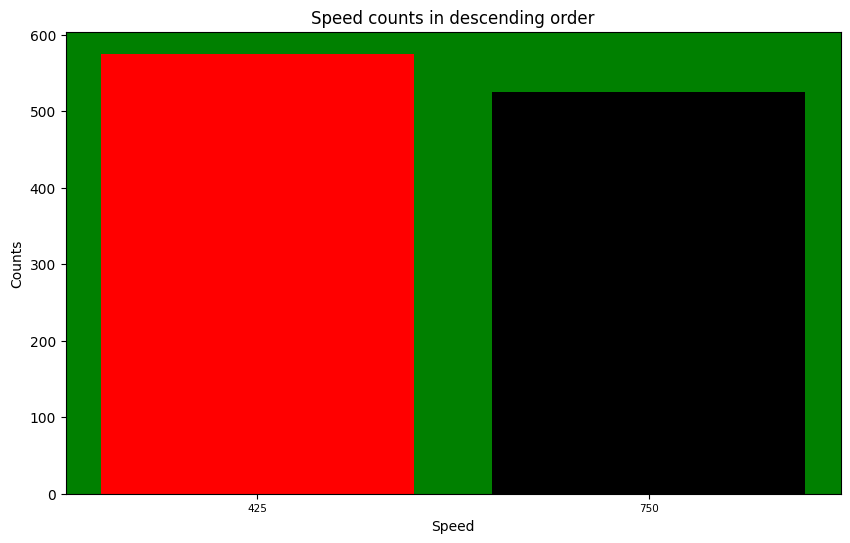

In [4]:
plot_sorted_counts(S, 'Speed', rot = 0)

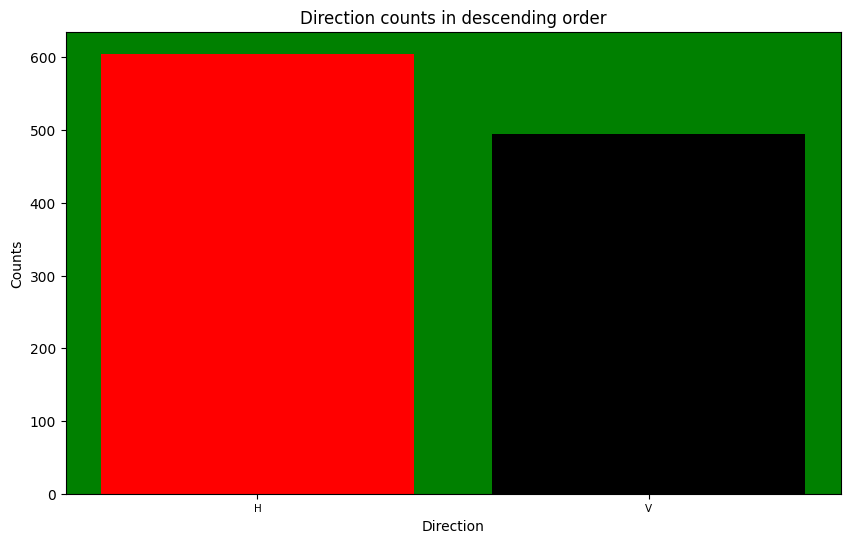

In [5]:
plot_sorted_counts(D, 'Direction', rot = 0)

['DAQ_1' 'DAQ_10' 'DAQ_11' 'DAQ_2' 'DAQ_3' 'DAQ_4' 'DAQ_5' 'DAQ_6' 'DAQ_7'
 'DAQ_8' 'DAQ_9'] [110 100  95 130  95  85 115 100  95 105  70]


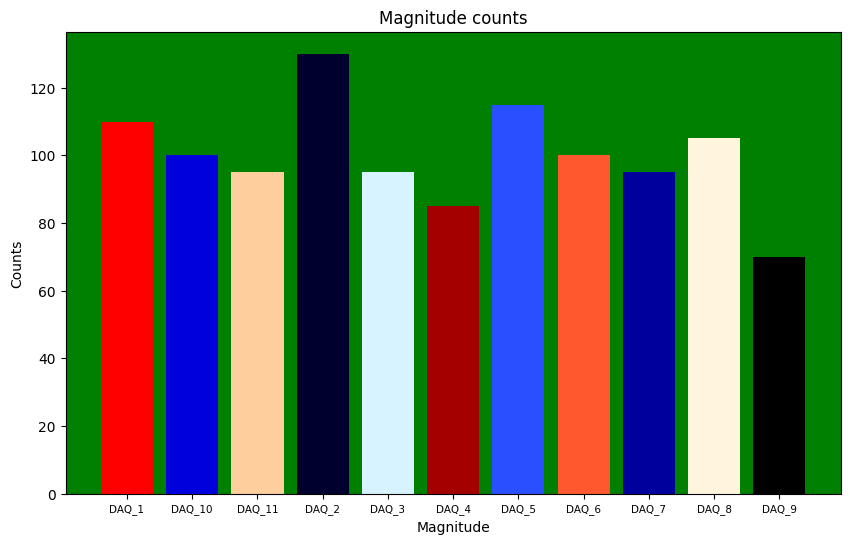

In [6]:
plot_sorted_counts(G, 'Magnitude', rot = 0, sorted=False)

In [7]:
newCols = pd.DataFrame()
newCols['OneHotDirGroup'] = Xmeta['direction'] + '_' + Xmeta['group'].str.split('_').str[1]

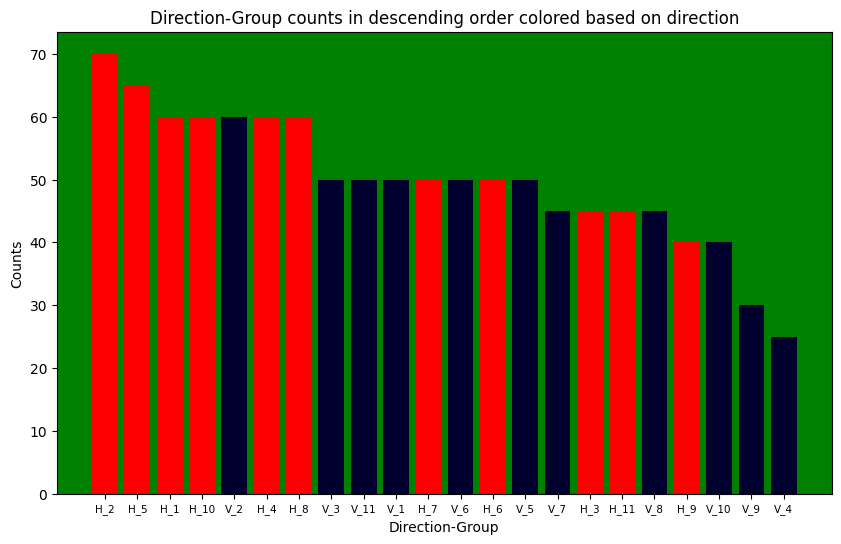

In [8]:
plot_sorted_counts(newCols['OneHotDirGroup'], 'Direction-Group', rot = 0, coloring = 'dir')

In [9]:
newCols['OneHotDirSpeed'] = Xmeta['direction'] + '_' + Xmeta['speed'].apply(lambda x: '425' if x <= 500 else '750')

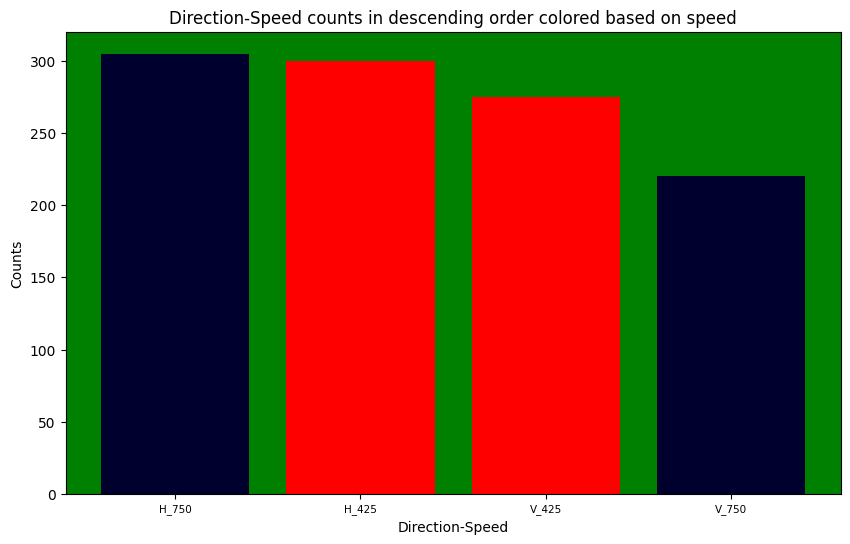

In [10]:
plot_sorted_counts(newCols['OneHotDirSpeed'], 'Direction-Speed', rot = 0, coloring = 'spd')

In [11]:
newCols['OneHotEvr'] = newCols['OneHotDirGroup'] + '_' + Xmeta['speed'].apply(lambda x: '425' if x <= 500 else '750')

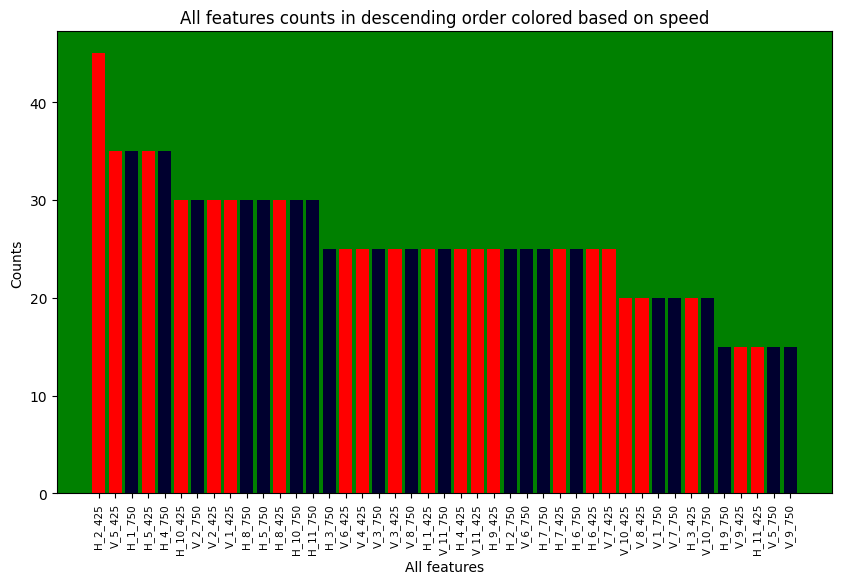

In [12]:
plot_sorted_counts(newCols['OneHotEvr'], 'All features', rot = 90, sorted = True, coloring = 'spd')

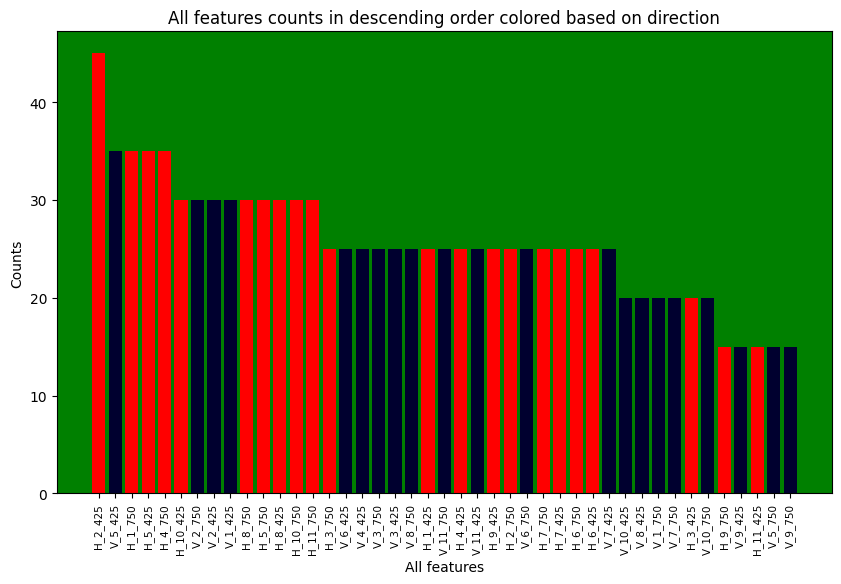

In [13]:
plot_sorted_counts(newCols['OneHotEvr'], 'All features', rot = 90, sorted = True, coloring = 'dir')

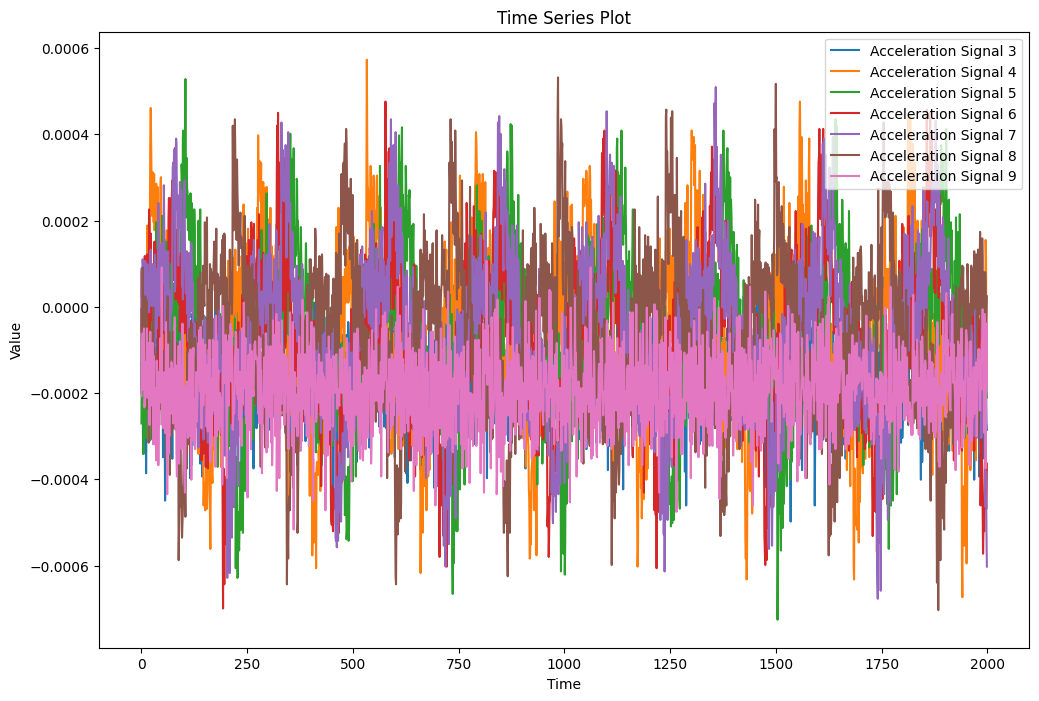

In [14]:
plot_series(3, 10, low = False, high = False, acc = True)

- store_wave_features(store = False)


- get_correlations(X)

In [15]:
Xwave = load_wave_features()

# get_correlations(Xwave)

## Visualizing Compressed Features per wave

- analyze(X, features, title, labels, scaler=None)

In [16]:
# # List of preprocessing techinques

# preprocessingList = [PowerTransformer()]


# # Choose which wave and store features (low, high, acc)
# wave = 'acc'
# features = []

# for feature in Xwave.columns:
#     if feature.startswith(wave):
#         features += [feature]

# # Visualize compressed features with preprocessing
# for pre in preprocessingList:
#     analyze(Xwave, features, str(pre)[:-2], Xmeta['label'], pre)


# # Visualize compressed features without any preprocessing (original data)
# # analyze(Xwave, features, 'Original', Xmeta['label'])

# Cross Validation

In [17]:
n_folds = 4

#StratifiedKFold
# cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state = 2211595)

#KFold
cv = KFold(n_splits=n_folds, shuffle=True, random_state = 2211595)

# Training

In [18]:
Xtrain = Xwave
Ytrain = Xmeta['label']

print('Shape of Xtrain:', Xtrain.shape)
print('Shape of Ytrain:', Ytrain.shape)

Shape of Xtrain: (1100, 88)
Shape of Ytrain: (1100,)


In [19]:
preprocessing = Pipeline([
                        ('pre1', MinMaxScaler()),
                         ]) 

feature_selection = Pipeline([('selectkbest', SelectKBest())]) 

regressor = Pipeline([('reg', Ridge())])

In [20]:
param_grid = {
    'feature_selection__selectkbest__k' : [88, 87, 86, 85, 84, 83, 82, 81,80],
    'regressor__reg__alpha' : [0.001, 0.01, 0.1, 1, 10]
}

In [21]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('regressor', regressor)])

gridsearch = GridSearchCV(pipeline, param_grid, n_jobs=4, cv=cv, scoring=mae_scorer, verbose=5, return_train_score=True)
gridsearch.fit(Xtrain, Ytrain)

results = gridsearch.cv_results_

train_score = results['mean_train_score'][gridsearch.best_index_]
validation_score = results['mean_test_score'][gridsearch.best_index_]

print()

print('Best params:')
print(gridsearch.best_params_)

print()

print('Training MAE {}'.format(train_score))
print('Validation MAE: {}'.format(validation_score))

print()

Fitting 4 folds for each of 45 candidates, totalling 180 fits

Best params:
{'feature_selection__selectkbest__k': 88, 'regressor__reg__alpha': 0.01}

Training MAE -0.19481179937830082
Validation MAE: -0.2053690187833157



# Error Analysis

- regression_error_analysis(gridsearch, Xtrain, Ytrain, cv)

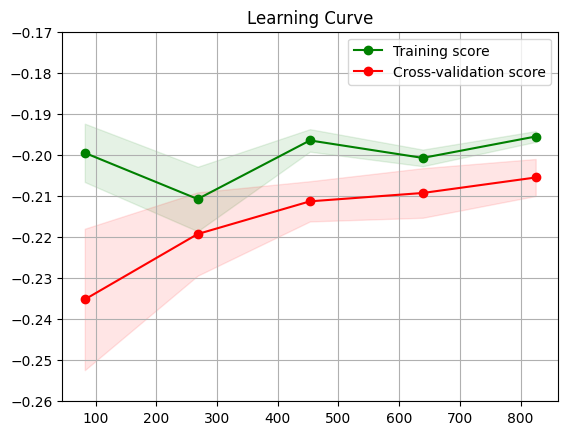

Fitting 4 folds for each of 45 candidates, totalling 180 fits
Fitting 4 folds for each of 45 candidates, totalling 180 fits
Fitting 4 folds for each of 45 candidates, totalling 180 fits
Fitting 4 folds for each of 45 candidates, totalling 180 fits


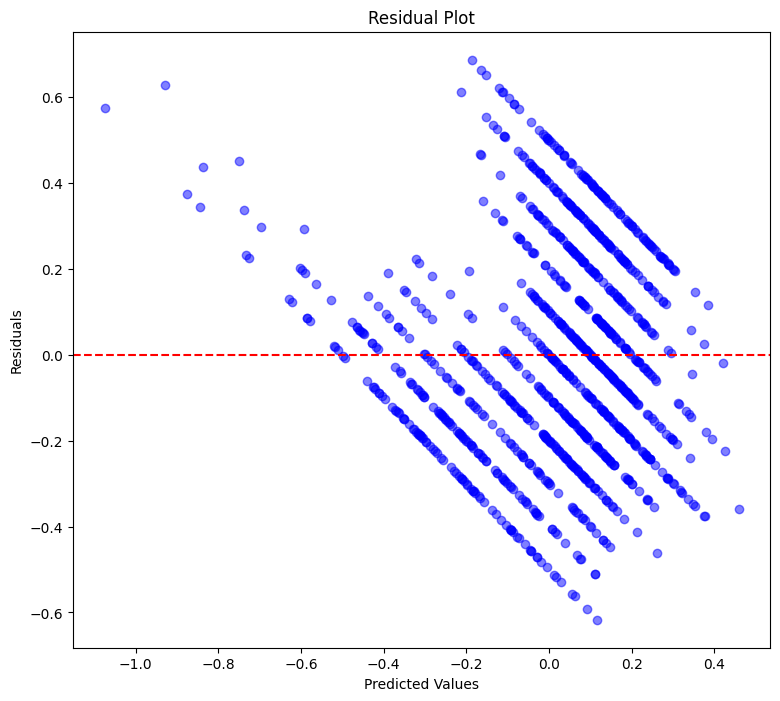

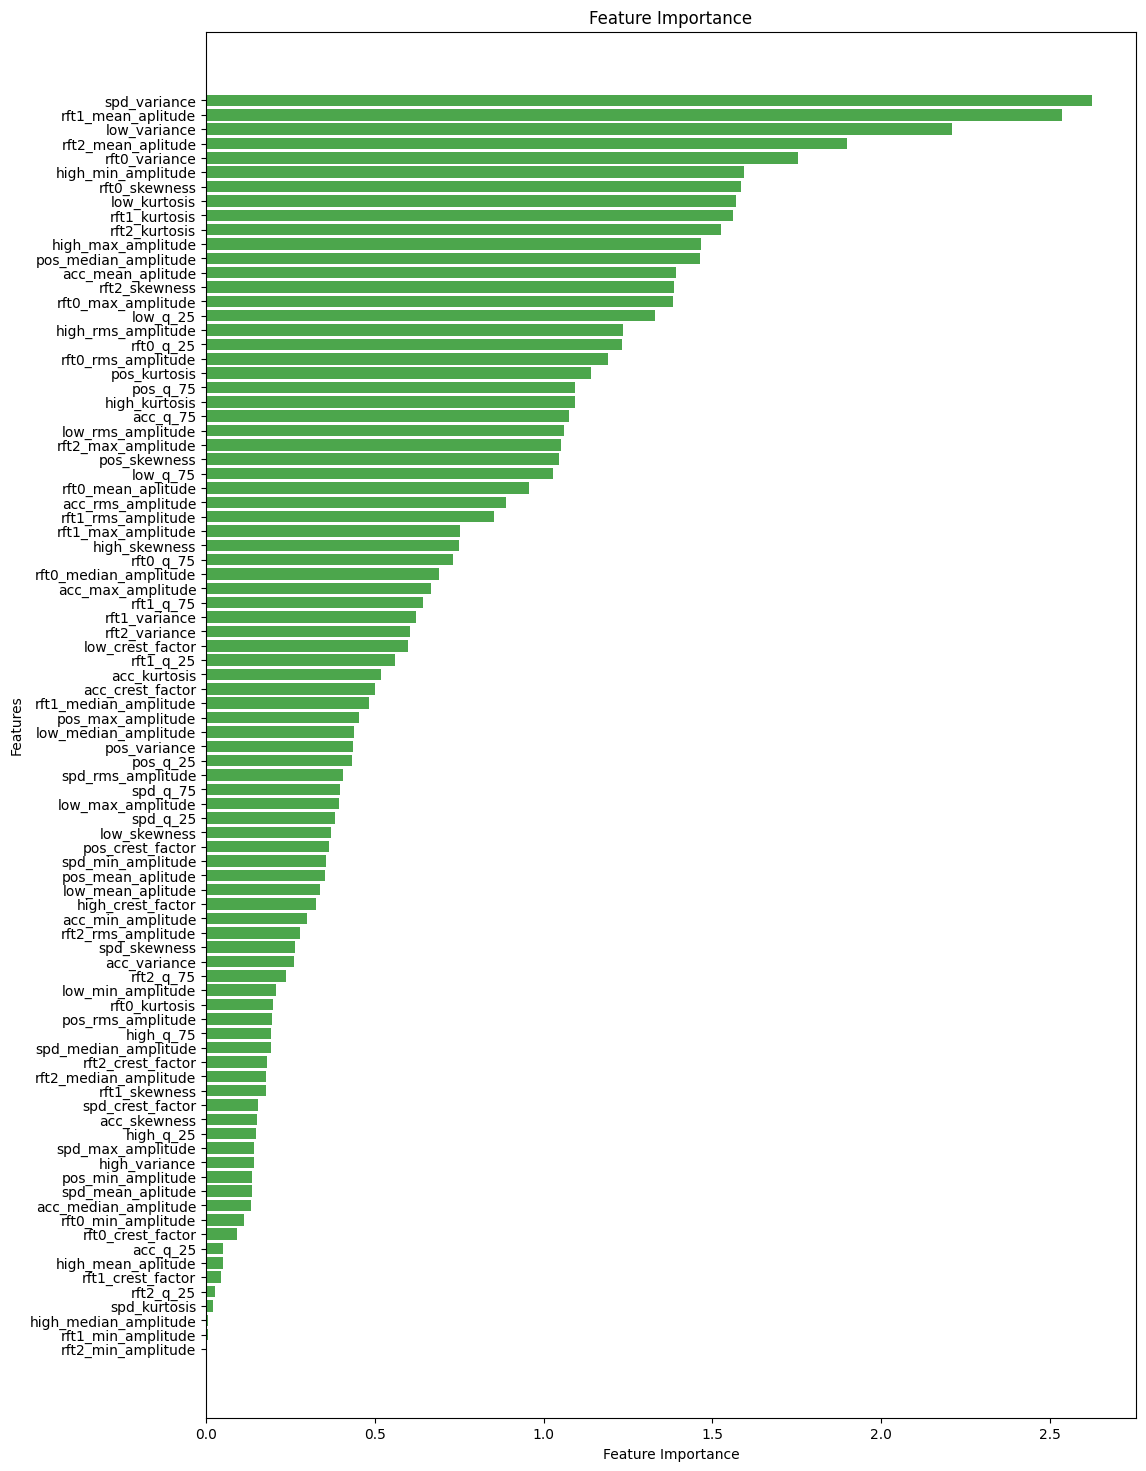

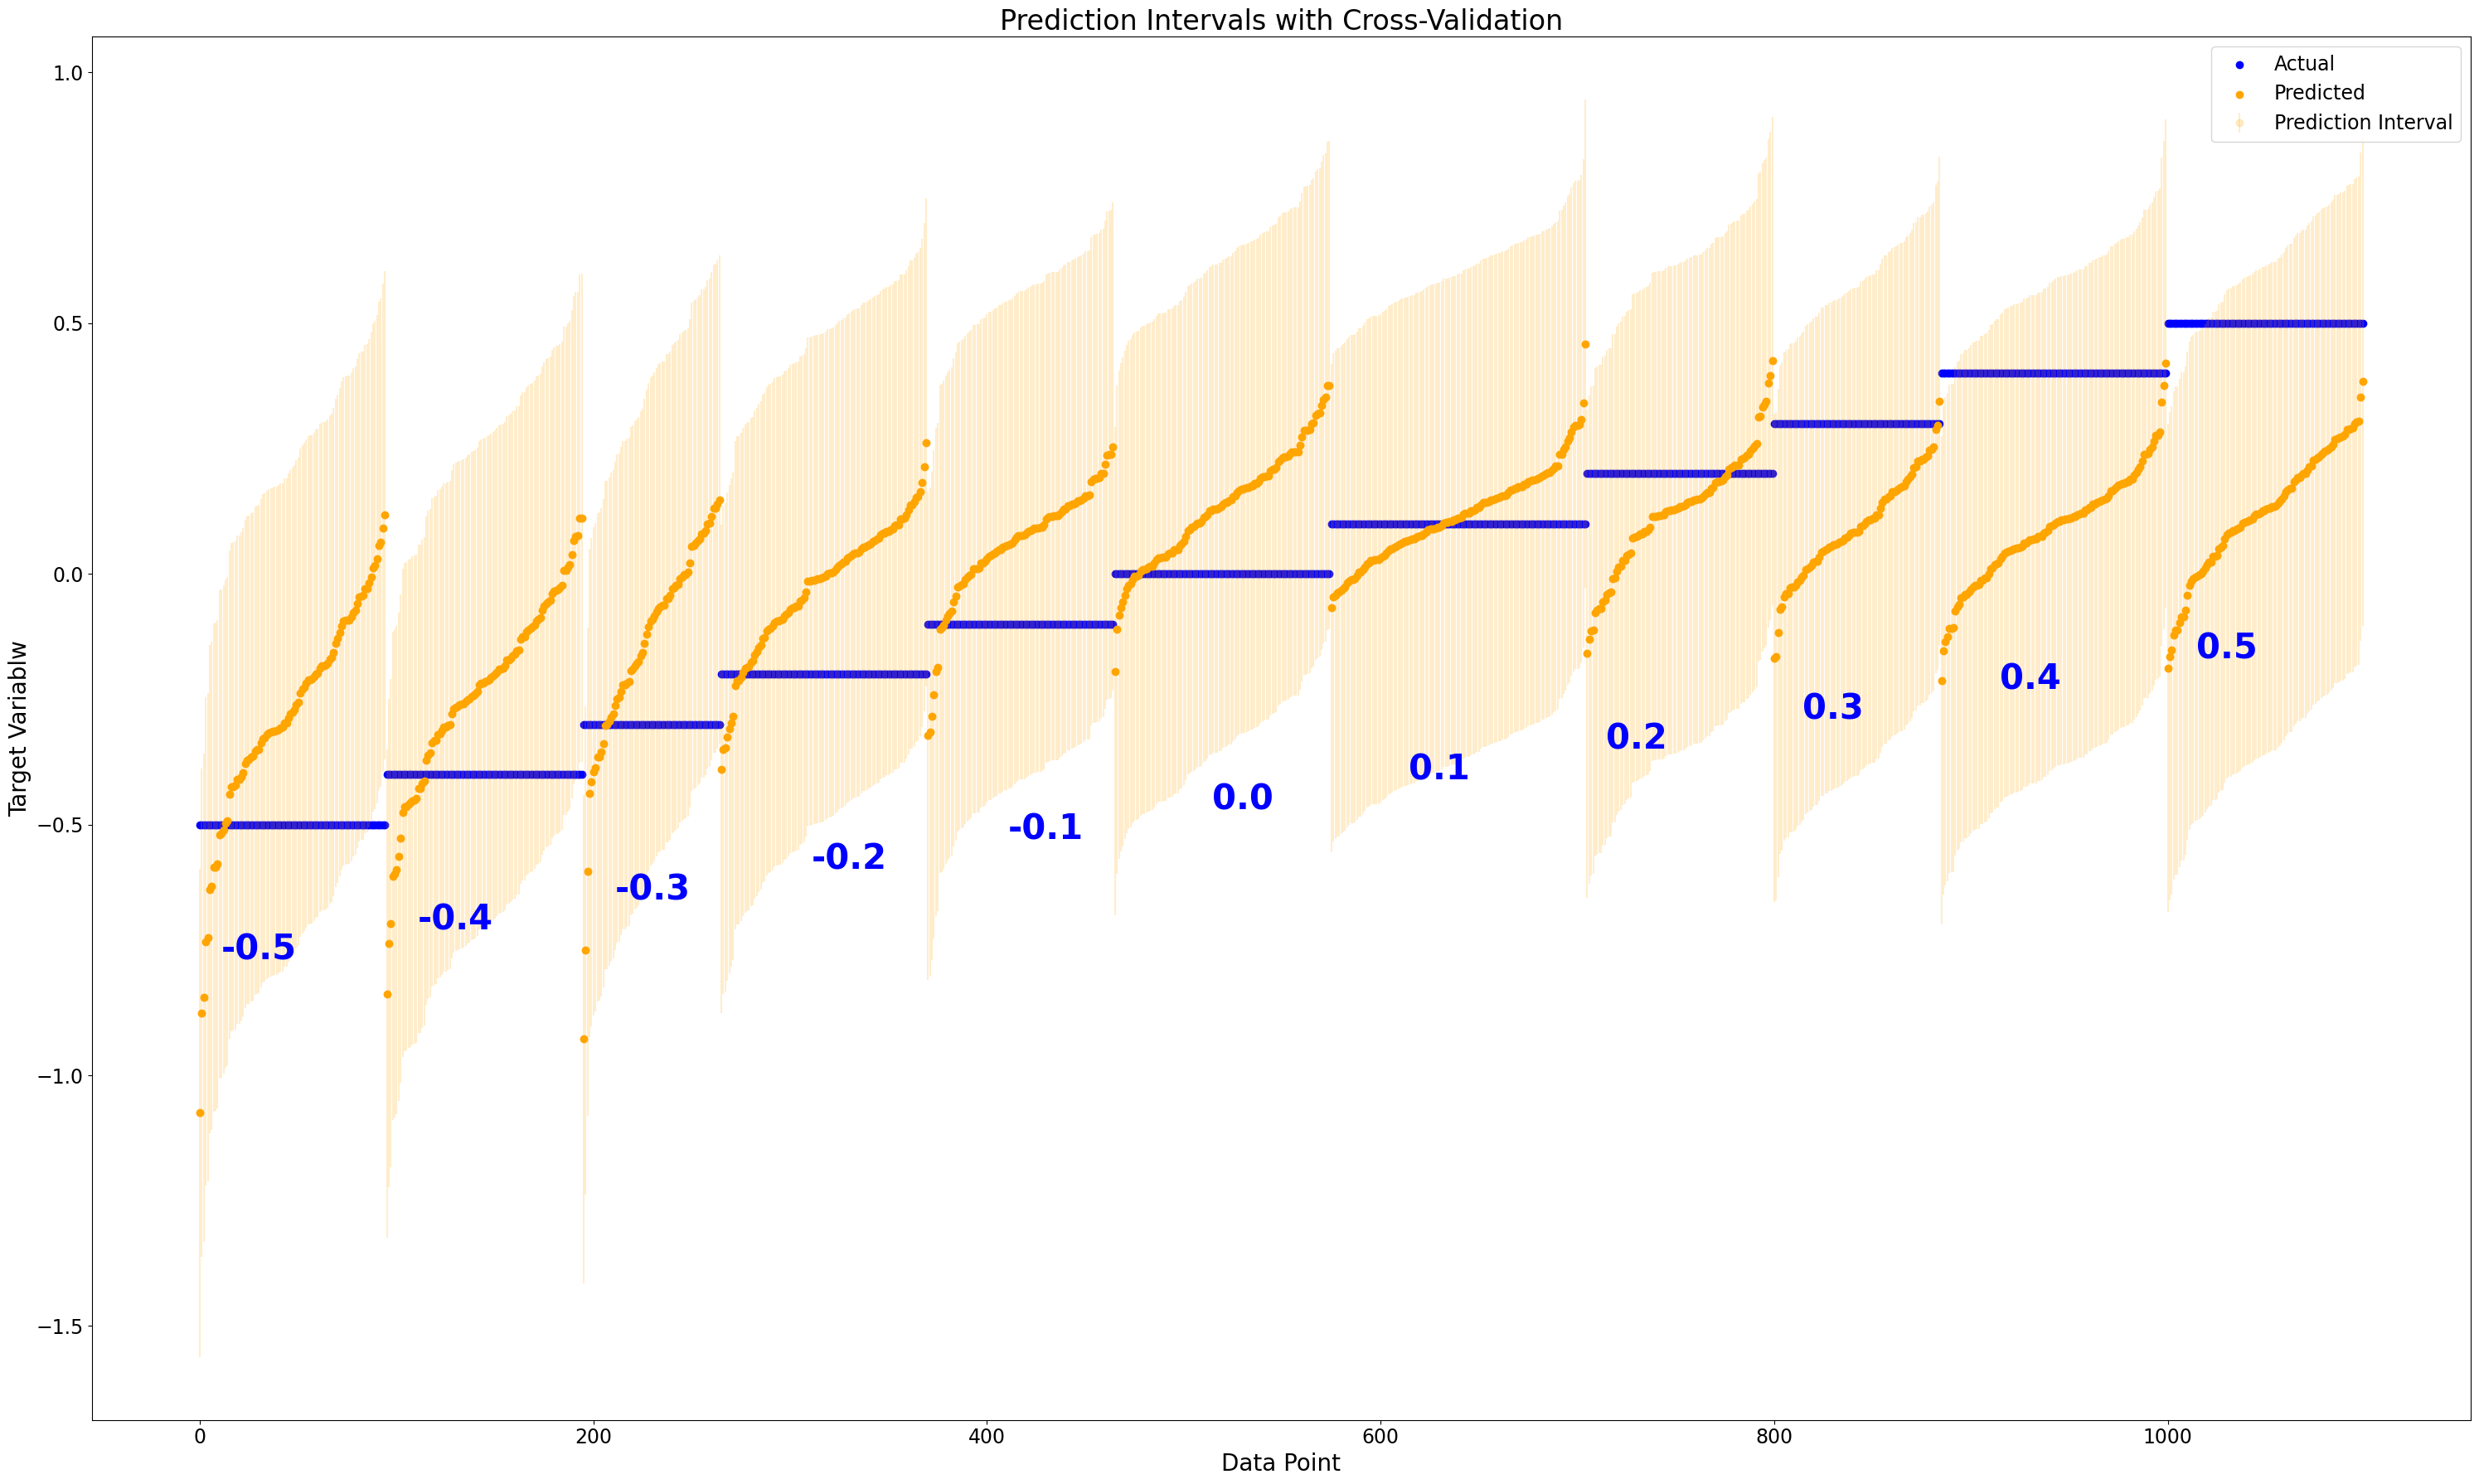

Cross-Validation Mean Absolute Error: 0.2055
Cross-Validation Mean Squared Error: 0.0616
Cross-Validation R-squared: 0.3679


In [23]:
regression_error_analysis(gridsearch, Xtrain, Ytrain, cv)

# Model Prediction

In [ ]:
# predict_and_store(model, store_wave_features)

In [ ]:
def done():
    winsound.Beep(300,200)
    winsound.Beep(400,200)
    winsound.Beep(500,200)
    winsound.Beep(600,200)
    winsound.Beep(400,200)
    winsound.Beep(600,400)

In [ ]:
# done()